# PCB Anomaly Detection

PCB Anomaly Detection is a computer vision-based machine learning solution. The algorithm identifies 6 different kinds of defects in PCBs namely: Missing Hole, Mouse Bite, Spur, Open Circuit, Short Circuit, Spurious copper. The algorithm takes reference PCB templates for analysis and identification of defects in erroneous PCB images.

### Contents

1. [Set up the environment](#Set-up-the-environment)
1. [Usage Instructions](#Usage-Instructions)
1. [Upload the data for training](#Upload-the-data-for-training)
1. [Creating Training Job using Algorithm ARN](#Creating-Training-Job-using-Algorithm-ARN)
1. [Run Training Job](#Run-Training-Job)
1. [Batch Transform Job](#Batch-Transform-Job)

## Using Algorithm ARN with Amazon SageMaker APIs

This sample notebook demonstrates:
1. Using an Algorithm ARN to run training jobs and use that result for inference

## Set up the environment

In [15]:
import sagemaker as sage
from sagemaker import get_execution_role

role = get_execution_role()

# S3 prefixes
common_prefix = "pcb-defect-detection"
training_input_prefix = common_prefix + "/training"
batch_inference_input_prefix = common_prefix + "/testing"

# Usage Instructions

### Input

Supported content types: `image/jpeg`

#### Input Schema: (For Training)
* Top view of non-erroneous, complete images of templates taken in portrait mode (no partial images)
* Vertical and Horizontal resolution of 72 dpi or more
* No shadow in images (for better performance)
* The images must have less background noise
* The template images must be straight and still images without any defects

#### Input Schema: (For Testing)
* Top view of complete image of PCBs taken in portrait mode (no partial image)
* Vertical and Horizontal resolution of 72 dpi or more
* No shadow in image (for better performance)
* The image must have less background noise


### Output

Content type: `image/jpeg`
* Output will be image with defects and bounding boxes around them
* The bounding box will have the name of defect on top of them out of the 6 types of defects – Missing hole, Mouse bite, Spur, Open circuit, Short circuit, Spurious copper.

### Create the session

The session remembers our connection parameters to Amazon SageMaker. We'll use it to perform all of our Amazon SageMaker operations.

In [16]:
sagemaker_session = sage.Session()

## Upload the data for training

In [18]:
TRAINING_WORKDIR = "./training"

training_input = sagemaker_session.upload_data(TRAINING_WORKDIR, key_prefix=training_input_prefix)
print ("Training Data Location " + training_input)

Training Data Location s3://sagemaker-us-east-2-786796469737/pcb-defect-detection/training


## Creating Training Job using Algorithm ARN

Please put in the algorithm arn you want to use below. This can either be an AWS Marketplace algorithm you subscribed to (or) one of the algorithms you created in your own account.


In [19]:
algorithm_arn = 'your arn number'

In [20]:
import json
import time
from sagemaker.algorithm import AlgorithmEstimator

algo = AlgorithmEstimator(
            algorithm_arn=algorithm_arn,
            role=role,
            instance_count=1,
            instance_type='ml.c4.xlarge',
            base_job_name='pcb-defect-detection-jupyter-test1')

## Run Training Job

In [21]:
print ("Now run the training job using algorithm arn %s in region %s" % (algorithm_arn, sagemaker_session.boto_region_name))
algo.fit({'training': training_input})

Now run the training job using algorithm arn arn:aws:sagemaker:us-east-2:786796469737:algorithm/pcb-defect-detection-v7 in region us-east-2
2022-04-21 06:36:20 Starting - Starting the training job...
2022-04-21 06:36:43 Starting - Preparing the instances for trainingProfilerReport-1650522979: InProgress
......
2022-04-21 06:37:46 Downloading - Downloading input data...
2022-04-21 06:38:11 Training - Downloading the training image..Starting the training.
11.JPG
06.JPG
09.JPG
05.JPG
01.JPG
07.JPG
12.JPG
10.JPG
04.JPG
08.JPG
Training complete.

2022-04-21 06:38:43 Uploading - Uploading generated training model
2022-04-21 06:38:43 Completed - Training job completed
Training seconds: 57
Billable seconds: 57


## Batch Transform Job

Now let's use the model built to run a batch inference job and verify it works.


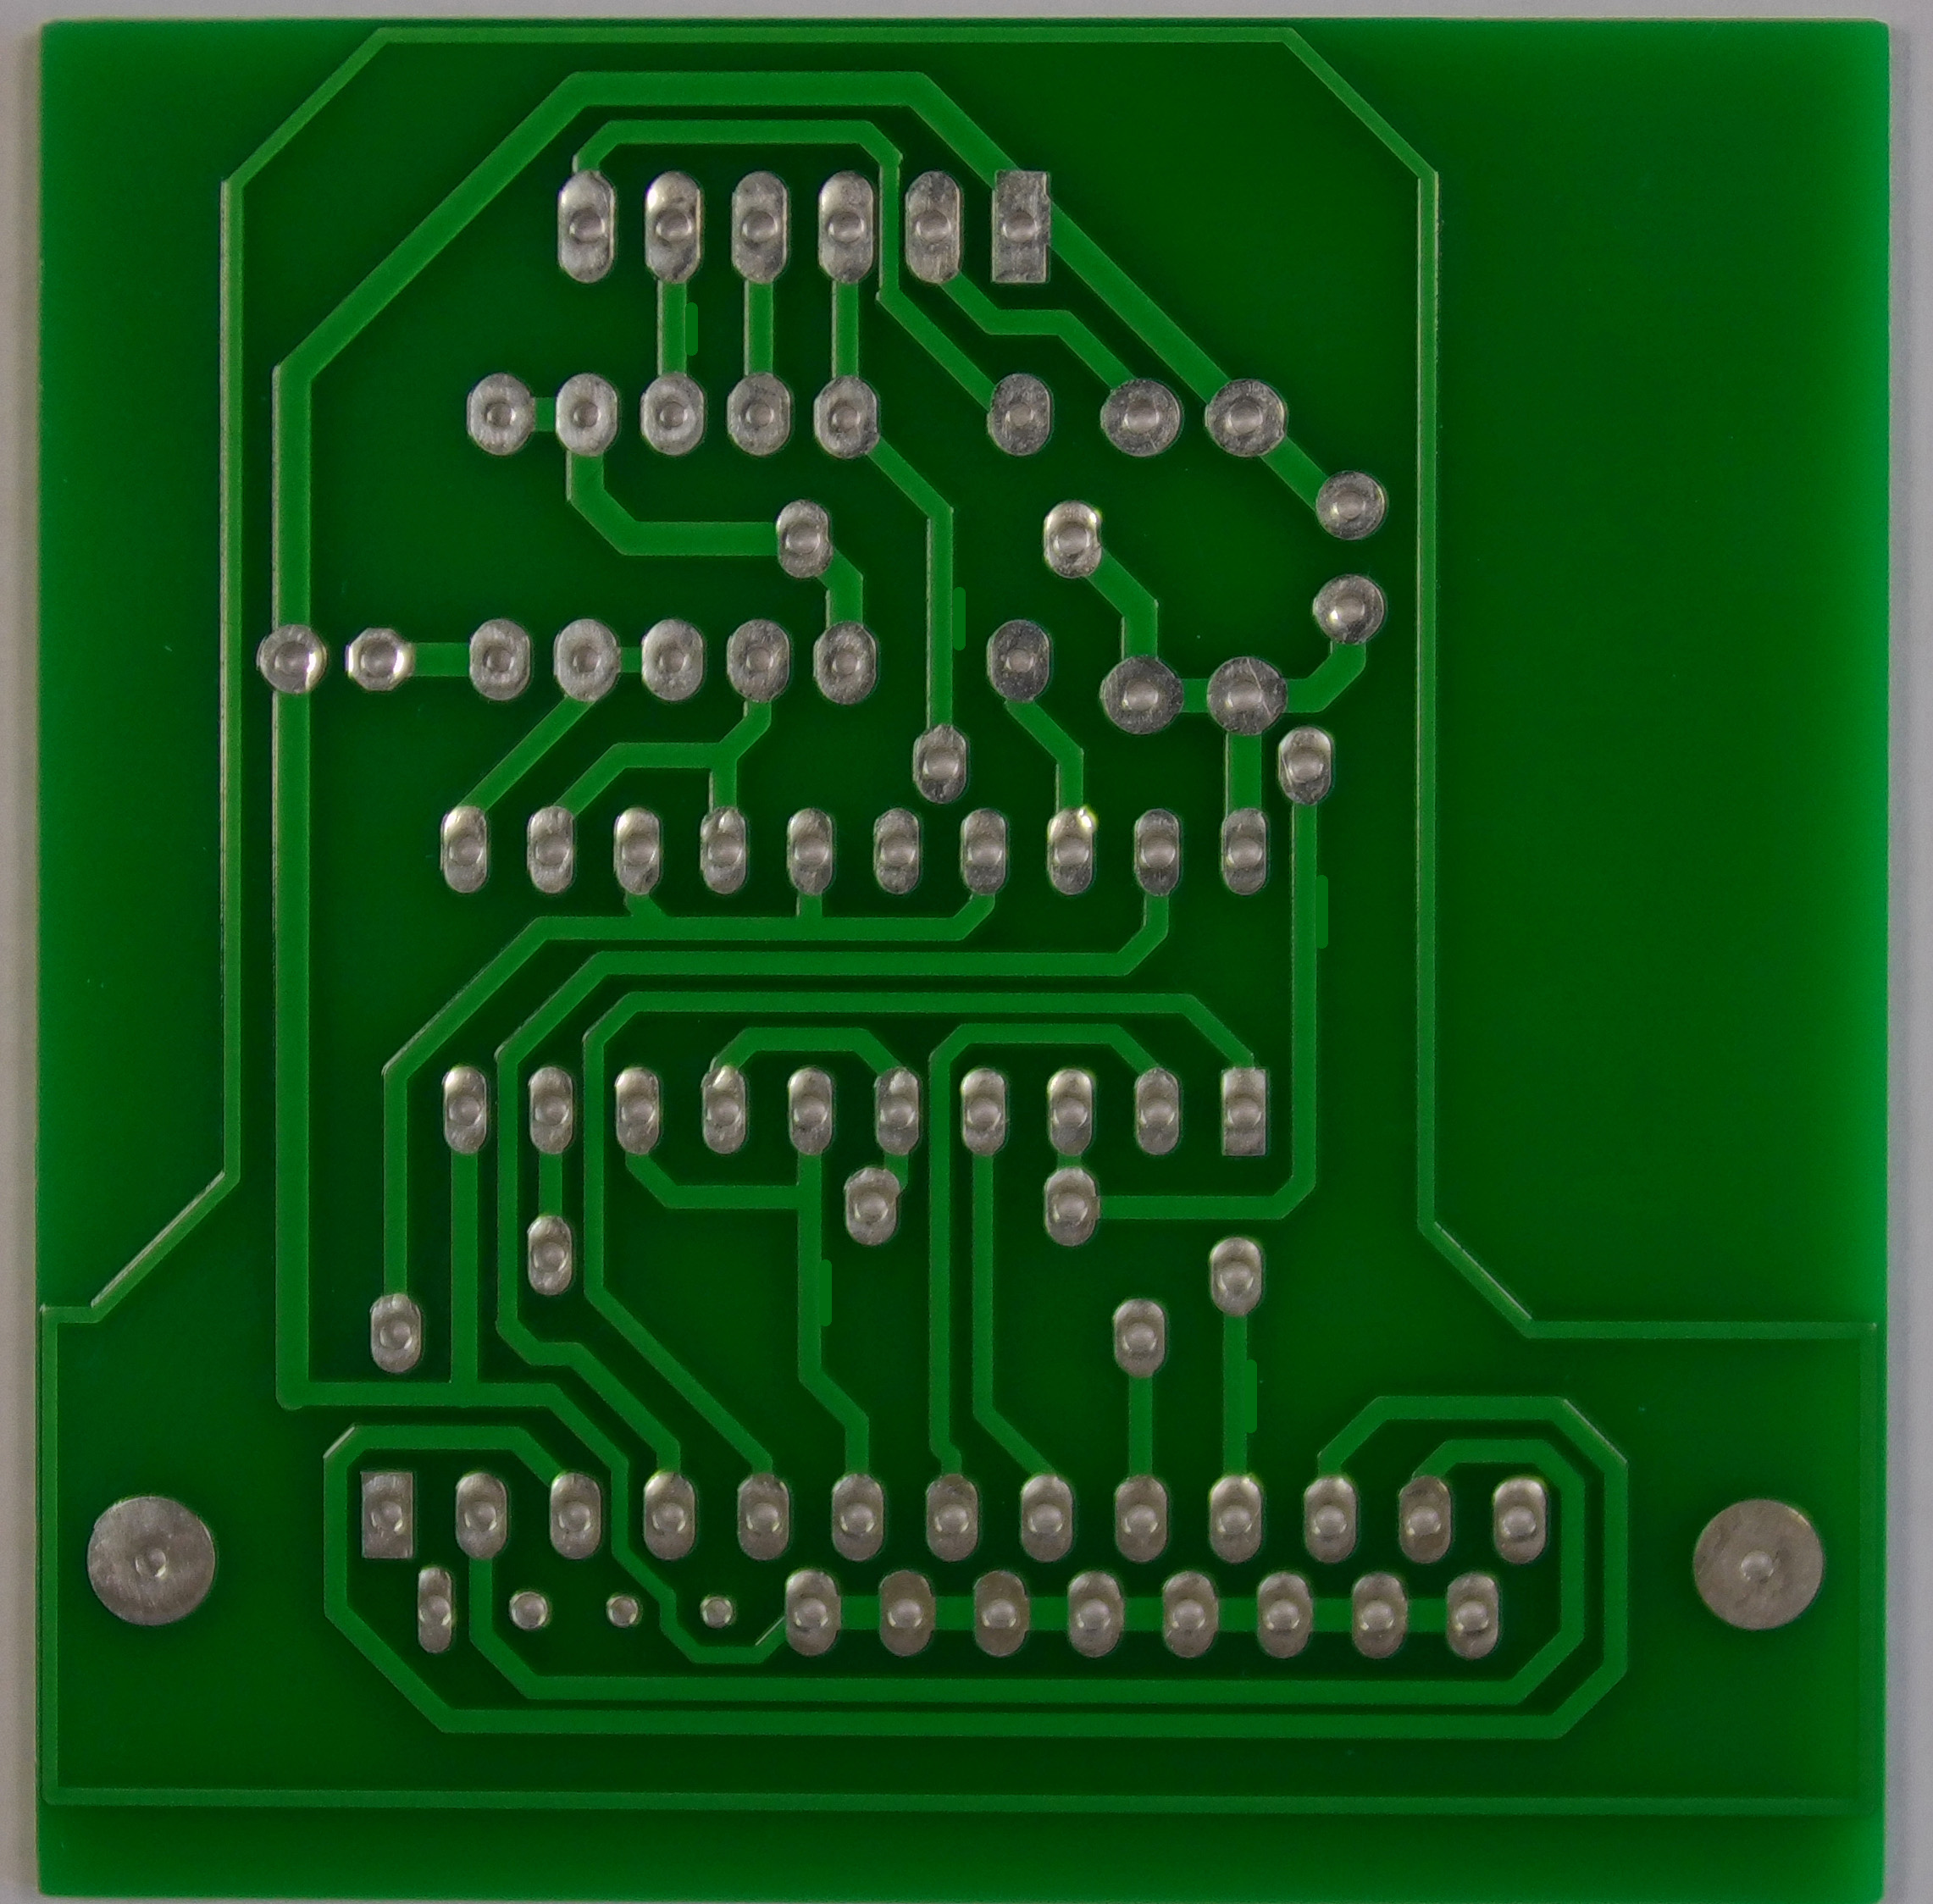

In [22]:
from IPython.display import Image, display
display(Image(filename='./testing/test.jpg'))

In [23]:
TRANSFORM_WORKDIR = "./testing"

transform_input = sagemaker_session.upload_data(TRANSFORM_WORKDIR, key_prefix=batch_inference_input_prefix) + "/test.jpg"
print("Transform input uploaded to " + transform_input)

Transform input uploaded to s3://sagemaker-us-east-2-786796469737/pcb-defect-detection/testing/test.jpg


In [24]:
transformer = algo.transformer(1, 'ml.m4.xlarge')
transformer.transform(transform_input, content_type='image/jpeg')
transformer.wait()

print("Batch Transform output saved to " + transformer.output_path)

..........
...........................
Starting the inference server with 4 workers.
[2022-04-21 06:44:15 +0000] [13] [INFO] Starting gunicorn 20.1.0
[2022-04-21 06:44:15 +0000] [13] [INFO] Listening at: unix:/tmp/gunicorn.sock (13)
[2022-04-21 06:44:15 +0000] [13] [INFO] Using worker: gevent
[2022-04-21 06:44:15 +0000] [17] [INFO] Booting worker with pid: 17
[2022-04-21 06:44:15 +0000] [18] [INFO] Booting worker with pid: 18
[2022-04-21 06:44:15 +0000] [19] [INFO] Booting worker with pid: 19
[2022-04-21 06:44:15 +0000] [20] [INFO] Booting worker with pid: 20
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

In [25]:
import boto3
print(transformer.output_path)
bucketFolder = transformer.output_path.rsplit('/')[3]
bucket_name=transformer.output_path.rsplit('/')[2]

#print(s3bucket,s3prefix)
s3_conn = boto3.client("s3")
with open('result.jpg', 'wb') as f:
    s3_conn.download_fileobj(bucket_name,bucketFolder+'/test.jpg.out', f)
    print("Output file loaded from bucket")

s3://sagemaker-us-east-2-786796469737/pcb-defect-detection-jupyter-test1-2022-04-21-06-39-57-920
Output file loaded from bucket


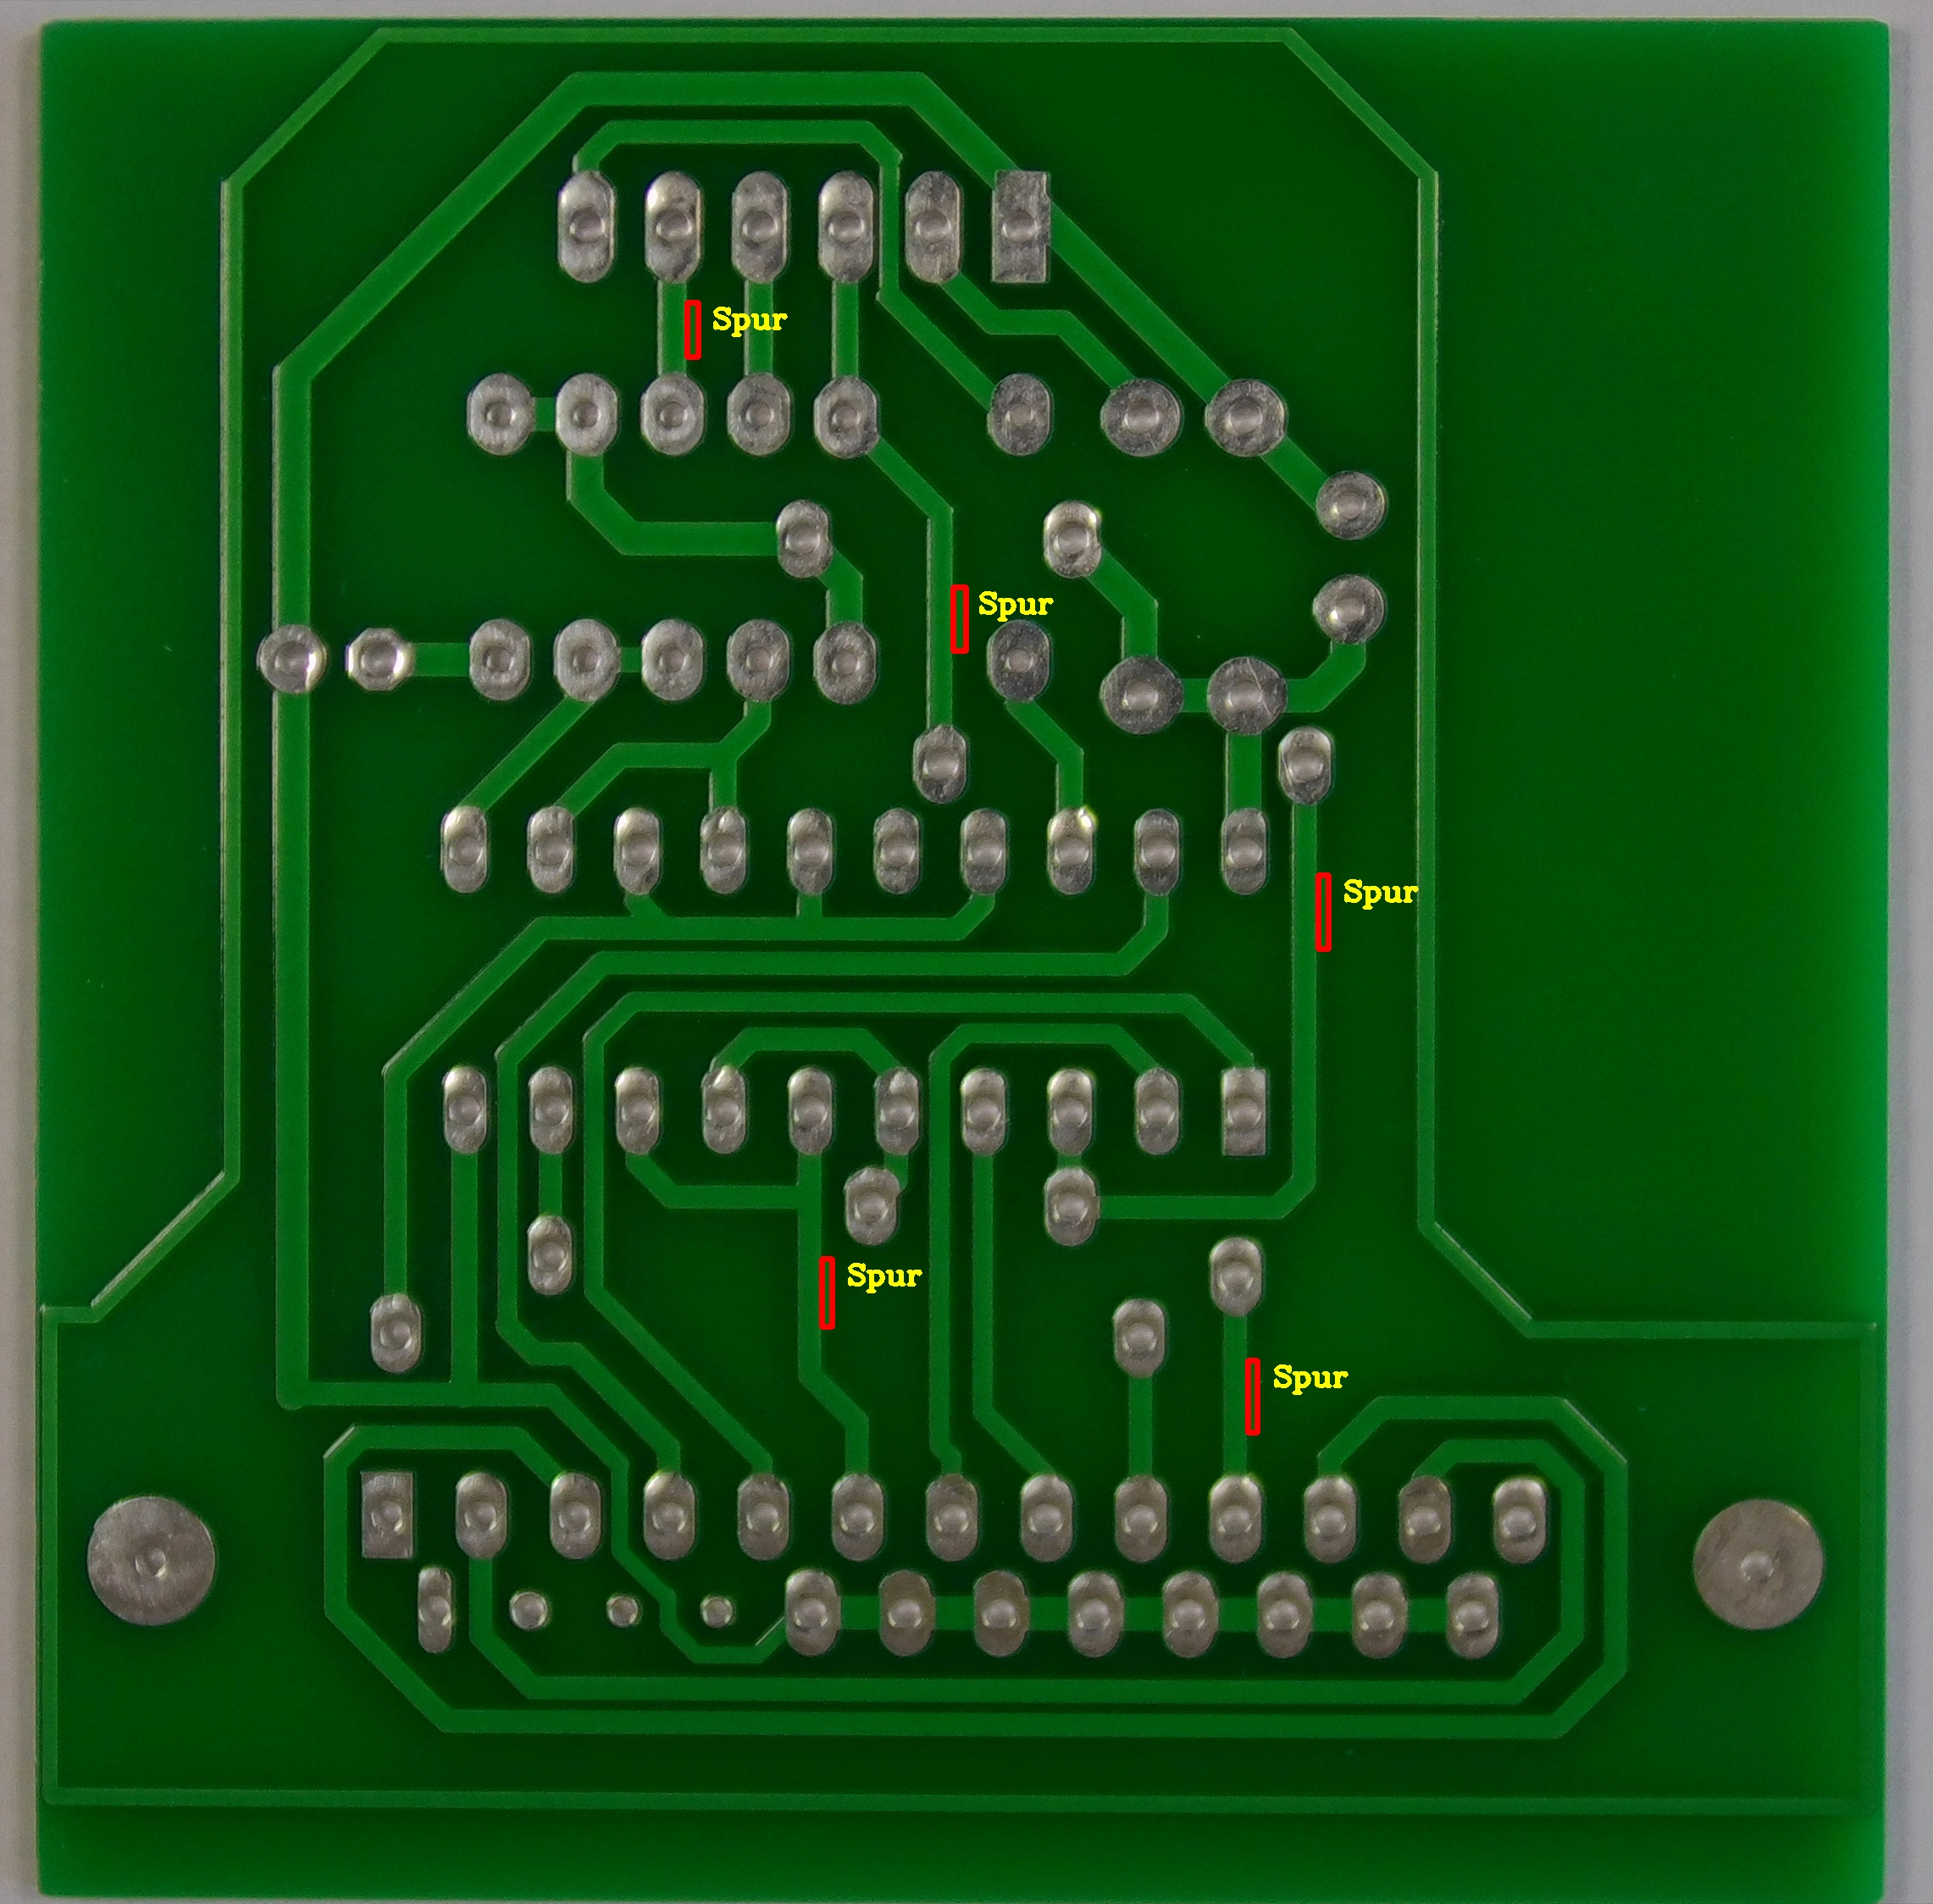

In [26]:
from IPython.display import Image, display
display(Image(filename='result.jpg'))